In [1]:
import os
import glob
from google.colab import drive
drive.mount('/content/drive')

base_dir = os.path.join('/content/drive/MyDrive/New')
infected_dir = os.path.join(base_dir,'/content/drive/MyDrive/New/Infected')
healthy_dir = os.path.join(base_dir,'/content/drive/MyDrive/New/Healthy')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(500, 500)

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['malaria'] * len(infected_files) + ['healthy'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,/content/drive/MyDrive/New/Healthy/C12NThinF_I...,healthy
1,/content/drive/MyDrive/New/Healthy/C217ThinF_I...,healthy
2,/content/drive/MyDrive/New/Healthy/C217ThinF_I...,healthy
3,/content/drive/MyDrive/New/Healthy/C1_thinF_IM...,healthy
4,/content/drive/MyDrive/New/Infected/C48P9thinF...,malaria


In [3]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,files_df['label'].values, test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(630,) (70,) (300,)
Train: Counter({'healthy': 317, 'malaria': 313}) 
Val: Counter({'healthy': 39, 'malaria': 31}) 
Test: Counter({'malaria': 156, 'healthy': 144})


In [4]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape

ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel,
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0))
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_2: working on img num: 629
Min Dimensions: [52 58  3]
Avg Dimensions: [128.94285714 130.3          3.        ]
Median Dimensions: [127. 130.   3.]
Max Dimensions: [220 187   3]


In [5]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS,
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel,
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_3: working on img num: 629

Loading Validation Images:
ThreadPoolExecutor-1_0: working on img num: 0
ThreadPoolExecutor-1_1: working on img num: 69

Loading Test Images:
ThreadPoolExecutor-1_1: working on img num: 0
ThreadPoolExecutor-1_1: working on img num: 299


((630, 125, 125, 3), (70, 125, 125, 3), (300, 125, 125, 3))

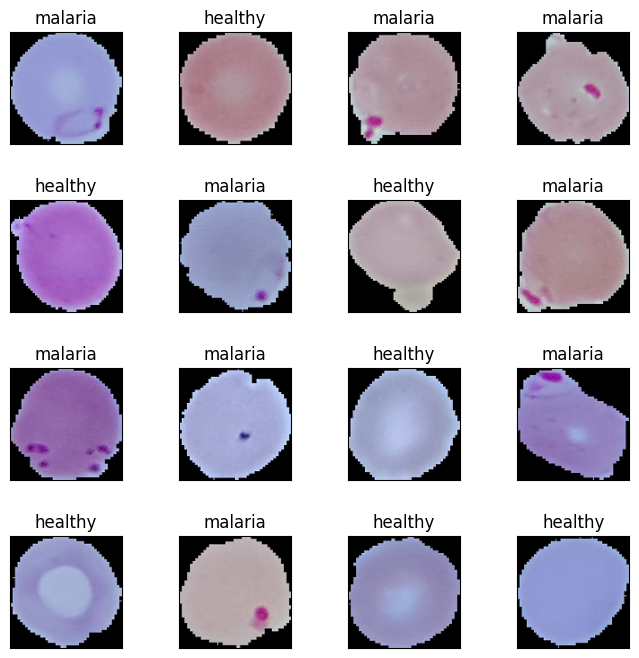

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0
for i in range(16):
    n += 1
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [7]:
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 10
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['malaria' 'malaria' 'healthy' 'healthy' 'healthy' 'healthy'] [1 1 0 0 0 0]


In [8]:
import tensorflow as tf
tf.random.set_seed(42)

In [9]:


def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model((125, 125, 3))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 123, 123, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 59, 59, 64)        256       
 chNormalization)                                                
                                                        

In [14]:
import datetime

logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs',
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    batch_size=BATCH_SIZE,
                    epochs=30,
                    validation_data=(val_imgs_scaled, val_labels_enc),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/30
20/20 [==============================] - 43s 2s/step - loss: 6.8167 - accuracy: 0.5698 - val_loss: 0.7142 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 2/30
20/20 [==============================] - 42s 2s/step - loss: 1.4188 - accuracy: 0.6206 - val_loss: 1.0326 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 32s 2s/step - loss: 0.7337 - accuracy: 0.6905 - val_loss: 1.4476 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 32s 2s/step - loss: 0.4468 - accuracy: 0.8000 - val_loss: 1.6360 - val_accuracy: 0.5571 - lr: 5.0000e-04
Epoch 5/30
20/20 [==============================] - 43s 2s/step - loss: 0.4372 - accuracy: 0.7921 - val_loss: 1.4151 - val_accuracy: 0.5857 - lr: 5.0000e-04
Epoch 6/30
20/20 [==============================] - 33s 2s/step - loss: 0.4224 - accuracy: 0.8333 - val_loss: 1.0847 - val_accuracy: 0.6143 - lr: 2.5000e-04
Epoch 7/30
20/20 [==============================] - 32s 2s/step - loss

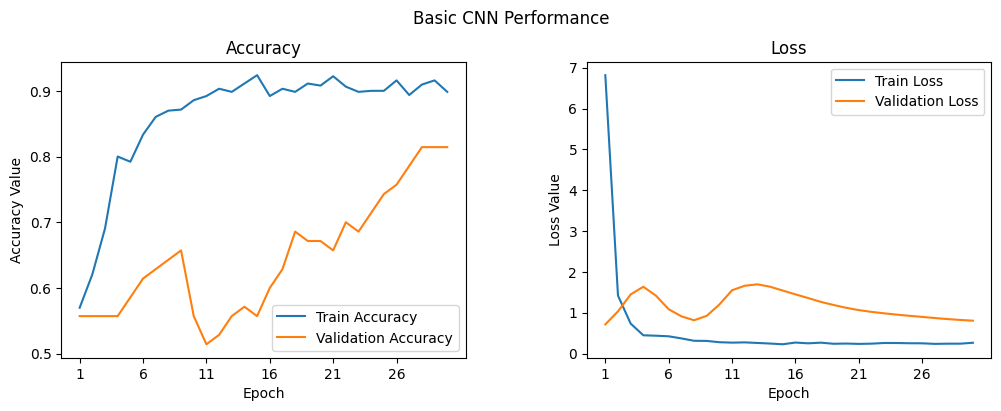

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [16]:
model.save('basic_cnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
 train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05,
                                                                rotation_range=25,
                                                                width_shift_range=0.05,
                                                                height_shift_range=0.05,
                                                                shear_range=0.05, horizontal_flip=True,
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: ['malaria', 'malaria', 'malaria', 'malaria', 'malaria']


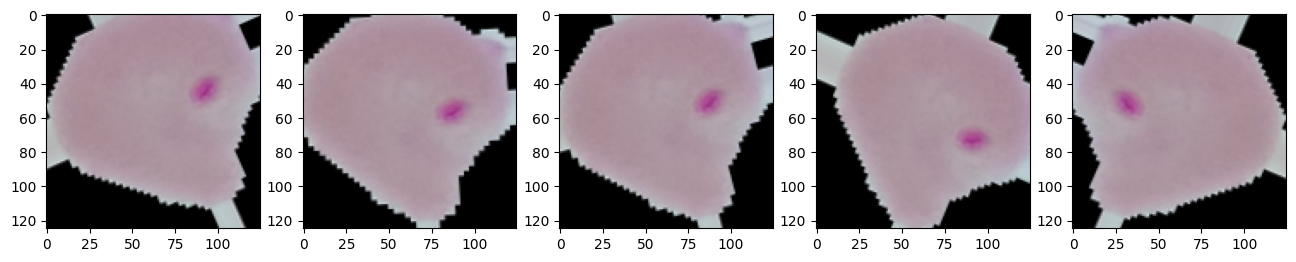

In [18]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [19]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((300, 125, 125, 3), (300,))

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D,ZeroPadding2D,Dropout


for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pre-trained model to the Sequential model
resnet_model.add(pretrained_model)

# Flatten the output of the pre-trained model
resnet_model.add(Flatten())

# Add a dense layer with softmax activation
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))  # Use softmax activation for classification

# Summary of the model
resnet_model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [22]:
from tensorflow import keras
from tensorflow.keras import optimizers

resnet_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15,
#                                              mode='auto', baseline=None, restore_best_weights=False)

# Train the model
history = resnet_model.fit(
    train_datagen.flow(train_data, train_labels_enc, batch_size=32),
    validation_data=val_datagen.flow(val_data, val_labels_enc),
    steps_per_epoch=len(train_data) // 32,
    validation_steps=len(val_data) // 32,
    epochs=50,
    callbacks=[reduce_lr],
    verbose=1
)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=30,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch,
                              verbose=1)

Epoch 1/30
19/19 [==============================] - 47s 2s/step - loss: 0.7656 - accuracy: 0.5217 - val_loss: 0.6281 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 2/30
19/19 [==============================] - 44s 2s/step - loss: 0.6824 - accuracy: 0.5769 - val_loss: 0.6096 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 3/30
19/19 [==============================] - 43s 2s/step - loss: 0.6870 - accuracy: 0.5853 - val_loss: 0.6011 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 4/30
19/19 [==============================] - 43s 2s/step - loss: 0.6664 - accuracy: 0.6003 - val_loss: 0.5603 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 5/30
19/19 [==============================] - 46s 2s/step - loss: 0.6928 - accuracy: 0.5753 - val_loss: 0.5753 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 6/30
19/19 [==============================] - 43s 2s/step - loss: 0.6784 - accuracy: 0.5686 - val_loss: 0.5605 - val_accuracy: 0.7344 - lr: 0.0010
Epoch 7/30
19/19 [==============================] - 46s 2s/step - loss: 0.6323 - a

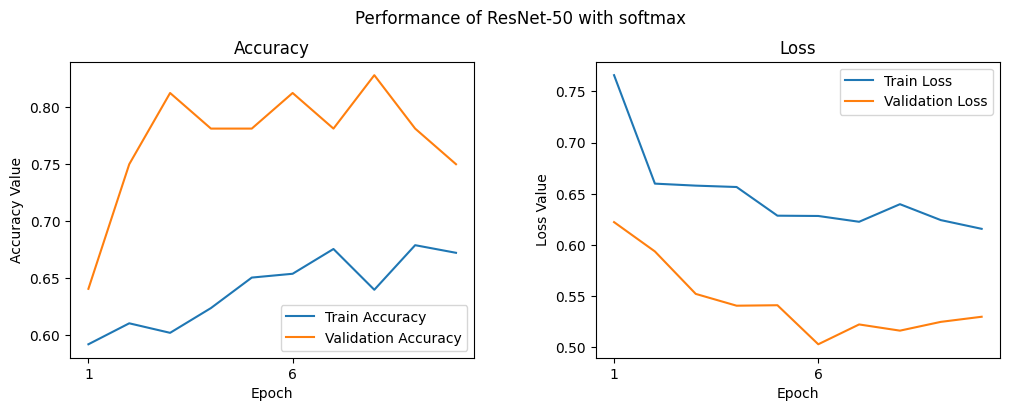

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance of ResNet-50 with softmax', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('resnet50_1.h5')

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D,ZeroPadding2D,Dropout


resnet1_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                                                 input_shape=(125,125,3),
                                                 pooling='max',classes=2,
                                                 weights='imagenet')
for layer in pretrained_model.layers:
  layer.trainable=False

resnet1_model.add(pretrained_model)
resnet1_model.add(Flatten())
resnet1_model.add(Dense(512,activation='relu'))
resnet1_model.add(Dense(2,activation='sigmoid'))

resnet1_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 dense_6 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers

opt = keras.optimizers.Adam(learning_rate=0.01)
resnet1_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15,
#                                              mode='auto', baseline=None, restore_best_weights=False)
callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=30,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch,
                              verbose=1)

Epoch 1/10


<ipython-input-24-535d3e0e29ec>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,


19/19 [==============================] - 28s 1s/step - loss: 0.6159 - accuracy: 0.6572 - val_loss: 0.4834 - val_accuracy: 0.7969
Epoch 2/10
19/19 [==============================] - 27s 1s/step - loss: 0.6014 - accuracy: 0.6923 - val_loss: 0.5195 - val_accuracy: 0.7500
Epoch 3/10
19/19 [==============================] - 27s 1s/step - loss: 0.6154 - accuracy: 0.6706 - val_loss: 0.5589 - val_accuracy: 0.7500
Epoch 4/10
19/19 [==============================] - 27s 1s/step - loss: 0.6108 - accuracy: 0.6727 - val_loss: 0.5219 - val_accuracy: 0.7812
Epoch 5/10
19/19 [==============================] - 30s 2s/step - loss: 0.5843 - accuracy: 0.7090 - val_loss: 0.5340 - val_accuracy: 0.7812
Epoch 6/10
19/19 [==============================] - 28s 1s/step - loss: 0.5843 - accuracy: 0.7090 - val_loss: 0.5241 - val_accuracy: 0.7656
Epoch 7/10
19/19 [==============================] - 28s 1s/step - loss: 0.5815 - accuracy: 0.7057 - val_loss: 0.5067 - val_accuracy: 0.8125
Epoch 8/10
19/19 [=============

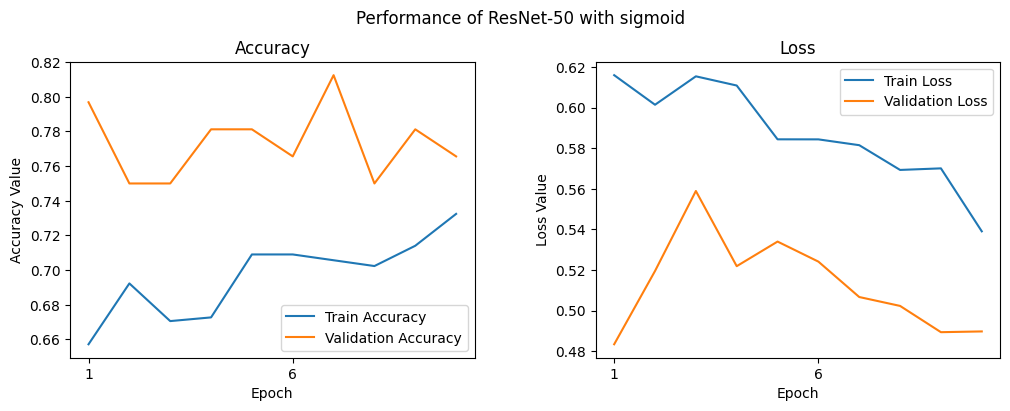

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance of ResNet-50 with sigmoid', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('resnet50_2.h5')

In [ ]:
basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')

resnet50_1=tf.keras.models.load_model('./resnet50_1.h5')

resnet50_2 = tf.keras.models.load_model('./resnet50_2.h5')

In [ ]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)

resnet50_preds1= resnet50_1.predict(test_imgs_scaled,batch_size=512)

resnet50_preds2= resnet50_2.predict(test_imgs_scaled,batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0
                                                  for pred in basic_cnn_preds.ravel()])

resnet50_pred_labels1 = le.inverse_transform([1 if pred > 0.5 else 0
                                                  for pred in resnet50_preds1.ravel()])

resnet50_pred_labels2= le.inverse_transform([1 if pred > 0.5 else 0
                                                  for pred in resnet50_preds2.ravel()])

1/1 [==============================] - 3s 3s/step


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

<Axes: >

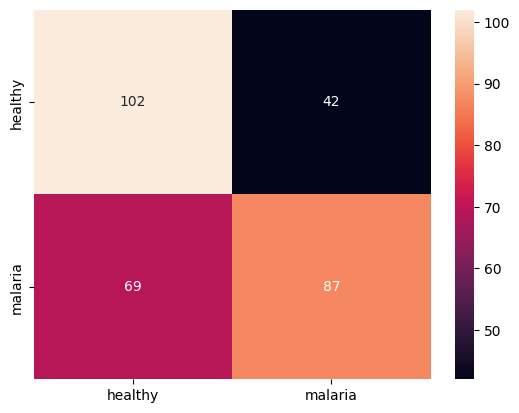

In [ ]:
classes=list(set(test_labels))

sns.heatmap(
    confusion_matrix(test_labels, basic_cnn_pred_labels),
    annot=True,
    fmt="d",
    xticklabels=classes,
    yticklabels=classes
)

<Axes: >

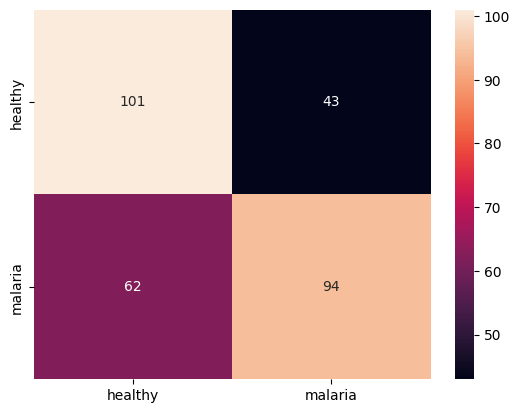

In [ ]:
classes=list(set(test_labels))

sns.heatmap(
    confusion_matrix(test_labels, resnet50_pred_labels1),
    annot=True,
    fmt="d",
    xticklabels=classes,
    yticklabels=classes
)

<Axes: >

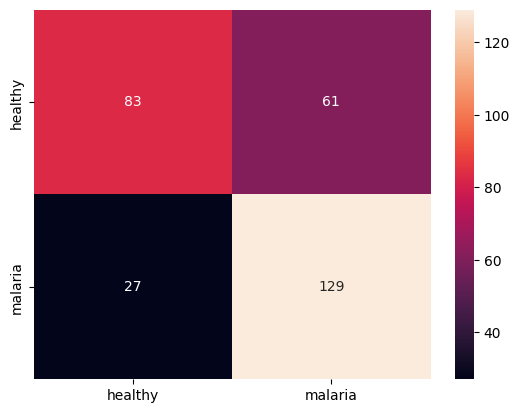

In [ ]:
classes=list(set(test_labels))

sns.heatmap(
    confusion_matrix(test_labels, resnet50_pred_labels2),
    annot=True,
    fmt="d",
    xticklabels=classes,
    yticklabels=classes
)

In [ ]:
print(classification_report(test_labels, basic_cnn_pred_labels))

              precision    recall  f1-score   support

     healthy       0.60      0.71      0.65       144
     malaria       0.67      0.56      0.61       156

    accuracy                           0.63       300
   macro avg       0.64      0.63      0.63       300
weighted avg       0.64      0.63      0.63       300



In [ ]:
print(classification_report(test_labels, resnet50_pred_labels1))

              precision    recall  f1-score   support

     healthy       0.62      0.70      0.66       144
     malaria       0.69      0.60      0.64       156

    accuracy                           0.65       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.65      0.65      0.65       300



In [ ]:
print(classification_report(test_labels, resnet50_pred_labels2))

              precision    recall  f1-score   support

     healthy       0.75      0.58      0.65       144
     malaria       0.68      0.83      0.75       156

    accuracy                           0.71       300
   macro avg       0.72      0.70      0.70       300
weighted avg       0.72      0.71      0.70       300



In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_labels, basic_cnn_pred_labels))

0.63


In [ ]:
print(accuracy_score(test_labels, resnet50_pred_labels1))

0.65


In [ ]:
print(accuracy_score(test_labels, resnet50_pred_labels2))

0.7066666666666667
